# Transformer Encoder-Only para Clasificación de Video (G5)

**Objetivo:** Clasificación de secuencias temporales con Transformer encoder-only
**Dataset:** 868 videos, 96 frames, 228 features por frame
**Clases:** 30 (ASL - American Sign Language)
**Hardware:** GTX 1660 Super (6GB)

In [29]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, 
    classification_report, top_k_accuracy_score
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: NVIDIA GeForce GTX 1660 SUPER
VRAM: 6.44 GB


In [30]:
# 1. CARGAR DATASET
dataset_path = Path('c:/Users/Los milluelitos repo/Desktop/tesis/experimentos/daataset/dataset_samples_normalizado_2.npz')
data = np.load(dataset_path, allow_pickle=True)

X = data['X']  # (868, 96, 228)
y = data['y']  # (868,)
masks = data['masks']  # (96,) - global mask
class_names = data['class_names']  # names

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Classes: {len(np.unique(y))}, Names: {len(class_names)}")
print(f"Unique classes: {np.unique(y)}")

# Generar mask per-sample (si cada video tiene su propia máscara de padding)
# En este caso, usaremos la misma máscara para todos
sample_masks = np.tile(masks, (X.shape[0], 1))  # (868, 96)
print(f"Sample masks shape: {sample_masks.shape}")

Dataset shape: X=(868, 96, 228), y=(868,)
Classes: 30, Names: 30
Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Sample masks shape: (868, 96)


In [31]:
# 2. DATASET PYTORCH
class VideoTransformerDataset(Dataset):
    def __init__(self, X, y, masks):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.masks = torch.BoolTensor(masks)  # True = válido, False = padding
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.X[idx],      # (96, 228)
            'label': self.y[idx],          # scalar
            'mask': self.masks[idx]        # (96,)
        }

# Train-test split (80-20)
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    X, y, sample_masks, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val, masks_train, masks_val = train_test_split(
    X_train, y_train, masks_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# DataLoaders
batch_size = 8
train_dataset = VideoTransformerDataset(X_train, y_train, masks_train)
val_dataset = VideoTransformerDataset(X_val, y_val, masks_val)
test_dataset = VideoTransformerDataset(X_test, y_test, masks_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Train: (555, 96, 228), Val: (139, 96, 228), Test: (174, 96, 228)
Batches - Train: 70, Val: 18, Test: 22


In [32]:
# 3. ARCHITECTURE: TRANSFORMER ENCODER-ONLY
class LearnablePositionalEncoding(nn.Module):
    """Positional encoding aprendible"""
    def __init__(self, d_model, max_len=96):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model))
        nn.init.normal_(self.pe, mean=0, std=0.02)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerEncoderOnlyClassifier(nn.Module):
    """
    Transformer Encoder-Only para clasificación de secuencias temporales
    - NO usa decoder
    - Usa masked mean pooling
    - Clasificación global por secuencia
    """
    def __init__(
        self,
        input_dim=228,
        d_model=256,
        num_heads=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1,
        num_classes=30,
        max_seq_len=96,
        mlp_dropout=0.2,
        activation='gelu'
    ):
        super().__init__()
        
        self.d_model = d_model
        
        # 1. Proyección inicial (228 → 256)
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # 2. Positional Encoding aprendible
        self.pos_encoding = LearnablePositionalEncoding(d_model, max_seq_len)
        self.dropout = nn.Dropout(dropout)
        
        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        # 4. Classification Head (MLP: 256 → 128 → num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, src, src_key_padding_mask=None):
        """
        Args:
            src: (batch_size, seq_len, input_dim) = (B, 96, 228)
            src_key_padding_mask: (batch_size, seq_len) = True para padding
        Returns:
            logits: (batch_size, num_classes)
        """
        # 1. Proyección inicial
        x = self.input_projection(src)  # (B, 96, 256)
        
        # 2. Positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # 3. Transformer encoder con máscara
        x = self.transformer_encoder(
            x,
            src_key_padding_mask=src_key_padding_mask
        )  # (B, 96, 256)
        
        # 4. Masked mean pooling (solo frames válidos)
        if src_key_padding_mask is not None:
            # src_key_padding_mask: True = padding (ignorar)
            # Convertir a float: 0 para padding, 1 para válido
            mask_float = (~src_key_padding_mask).float().unsqueeze(-1)  # (B, 96, 1)
            x_masked = x * mask_float  # (B, 96, 256)
            sum_masked = x_masked.sum(dim=1)  # (B, 256)
            count_valid = mask_float.sum(dim=1)  # (B, 1)
            x_pooled = sum_masked / (count_valid + 1e-9)  # (B, 256)
        else:
            # Sin máscara: mean pooling simple
            x_pooled = x.mean(dim=1)  # (B, 256)
        
        # 5. Clasificador
        logits = self.classifier(x_pooled)  # (B, num_classes)
        
        return logits

# Crear modelo
num_classes = len(np.unique(y))
model = TransformerEncoderOnlyClassifier(
    input_dim=228,
    d_model=256,
    num_heads=4,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1,
    num_classes=num_classes,
    max_seq_len=96,
    mlp_dropout=0.2,
    activation='gelu'
).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModelo:")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(model)


Modelo:
Total params: 2,228,894
Trainable params: 2,228,894
TransformerEncoderOnlyClassifier(
  (input_projection): Linear(in_features=228, out_features=256, bias=True)
  (pos_encoding): LearnablePositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256

In [33]:
# 4. ENTRENAMIENTO - CONFIG
config = {
    'optimizer': 'AdamW',
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'loss': 'CrossEntropyLoss',
    'label_smoothing': 0.1,
    'batch_size': 8,
    'max_epochs': 50,
    'early_stopping_patience': 8,
    'gradient_clip': 1.0,
    'num_classes': num_classes,
    'device': str(device)
}

# Loss con label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay']
)

# LR Scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=1, eta_min=1e-6
)

print("Configuración de entrenamiento:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuración de entrenamiento:
  optimizer: AdamW
  lr: 0.0001
  weight_decay: 0.0001
  loss: CrossEntropyLoss
  label_smoothing: 0.1
  batch_size: 8
  max_epochs: 50
  early_stopping_patience: 8
  gradient_clip: 1.0
  num_classes: 30
  device: cuda


In [34]:
# 5. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
def train_epoch(model, loader, criterion, optimizer, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Train", leave=False):
        sequences = batch['sequence'].to(device)  # (B, 96, 228)
        labels = batch['label'].to(device)        # (B,)
        masks = batch['mask'].to(device)          # (B, 96)
        
        # Forward
        logits = model(sequences, src_key_padding_mask=~masks)
        loss = criterion(logits, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_logits = []
    
    for batch in tqdm(loader, desc="Eval", leave=False):
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        
        logits = model(sequences, src_key_padding_mask=~masks)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())
    
    epoch_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_logits)

print("Funciones de entrenamiento definidas ✓")

Funciones de entrenamiento definidas ✓


In [ ]:
# 6. ENTRENAMIENTO PRINCIPAL
training_log = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_epoch = 0
patience_counter = 0
max_epochs = config['max_epochs']
early_stopping_patience = config['early_stopping_patience']

print(f"\n{'='*80}")
print(f"Iniciando entrenamiento - Epoch max: {max_epochs}, Patience: {early_stopping_patience}")
print(f"{'='*80}\n")

for epoch in range(max_epochs):
    # Entrenamiento
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, 
        grad_clip=config['gradient_clip']
    )
    
    # Validación
    val_loss, val_acc, _, _, _ = eval_epoch(model, val_loader, criterion, device)
    
    # LR Scheduler
    scheduler.step(epoch)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Log
    training_log['epoch'].append(epoch + 1)
    training_log['train_loss'].append(train_loss)
    training_log['train_acc'].append(train_acc)
    training_log['val_loss'].append(val_loss)
    training_log['val_acc'].append(val_acc)
    training_log['lr'].append(current_lr)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        # Guardar mejor modelo
        torch.save(model.state_dict(), 'c:/Users/Los milluelitos repo/Desktop/tesis/experimentos/E. json/best_model.pt')
    else:
        patience_counter += 1
    
    # Print
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"[Epoch {epoch+1:3d}/{max_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"LR: {current_lr:.2e} | Patience: {patience_counter}/{early_stopping_patience}")
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\n✓ Early stopping en epoch {epoch+1}")
        break

print(f"\n{'='*80}")
print(f"Entrenamiento completado. Mejor epoch: {best_epoch} (Val Acc: {best_val_acc:.4f})")
print(f"{'='*80}\n")

# Cargar mejor modelo
model.load_state_dict(torch.load('c:/Users/Los milluelitos repo/Desktop/tesis/experimentos/E. json/best_model.pt'))
model.eval()


Iniciando entrenamiento - Epoch max: 50, Patience: 8



[Epoch   1/50] Train Loss: 3.3029 | Train Acc: 0.0883 | Val Loss: 3.1919 | Val Acc: 0.1367 | LR: 1.00e-04 | Patience: 0/8


[Epoch   5/50] Train Loss: 2.2970 | Train Acc: 0.4144 | Val Loss: 2.2365 | Val Acc: 0.4317 | LR: 6.58e-05 | Patience: 0/8


[Epoch  10/50] Train Loss: 1.8654 | Train Acc: 0.5766 | Val Loss: 1.9695 | Val Acc: 0.4820 | LR: 3.42e-06 | Patience: 1/8


Train:  10%|█         | 7/70 [00:00<00:00, 63.93it/s] 

In [ ]:
# 7. EVALUACIÓN EN TEST SET
print("Evaluando en Test Set...")
test_loss, test_acc, test_preds, test_labels, test_logits = eval_epoch(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Métricas adicionales
macro_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)
top3_acc = top_k_accuracy_score(test_labels, test_logits, k=3, labels=np.arange(num_classes))

print(f"Macro-F1: {macro_f1:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")

# F1 por clase
f1_per_class = f1_score(test_labels, test_preds, average=None, zero_division=0)
print(f"\nF1 Score por clase (primeras 5 clases):")
for i in range(min(5, num_classes)):
    print(f"  Clase {i}: {f1_per_class[i]:.4f}")

# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
print(f"\nMatriz de confusión shape: {cm.shape}")

Evaluando en Test Set...



Test Loss: 1.1682
Test Accuracy: 0.8276
Macro-F1: 0.7743
Top-3 Accuracy: 0.9483

F1 Score por clase (primeras 5 clases):
  Clase 0: 0.7500
  Clase 1: 0.6667
  Clase 2: 0.8571
  Clase 3: 0.4000
  Clase 4: 1.0000

Matriz de confusión shape: (30, 30)


In [ ]:
# 8. GUARDAR RESULTADOS
output_dir = Path('c:/Users/Los milluelitos repo/Desktop/tesis/experimentos/E. json/')
output_dir.mkdir(exist_ok=True)

# 8.1 Training Log CSV
df_training = pd.DataFrame(training_log)
training_log_path = output_dir / 'training_log_g5.csv'
df_training.to_csv(training_log_path, index=False)
print(f"✓ Guardado: {training_log_path}")

# 8.2 Results CSV
results = {
    'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc, macro_f1, top3_acc, test_loss]
}
df_results = pd.DataFrame(results)
results_path = output_dir / 'results_g5.csv'
df_results.to_csv(results_path, index=False)
print(f"✓ Guardado: {results_path}")

# 8.3 Per-class metrics CSV
class_report = classification_report(
    test_labels, test_preds, 
    output_dict=True, 
    zero_division=0
)
df_per_class = pd.DataFrame(class_report).T
per_class_path = output_dir / 'per_class_g5.csv'
df_per_class.to_csv(per_class_path)
print(f"✓ Guardado: {per_class_path}")

# 8.4 Confusion Matrix CSV
cm_df = pd.DataFrame(cm)
confusion_path = output_dir / 'confusion_g5.csv'
cm_df.to_csv(confusion_path, index=False, header=False)
print(f"✓ Guardado: {confusion_path}")

# 8.5 Model Config JSON
model_config = {
    'architecture': 'TransformerEncoderOnly',
    'input_dim': 228,
    'd_model': 256,
    'num_heads': 4,
    'num_layers': 4,
    'dim_feedforward': 512,
    'dropout': 0.1,
    'num_classes': num_classes,
    'max_seq_len': 96,
    'mlp_dropout': 0.2,
    'activation': 'gelu',
    'total_params': total_params,
    'trainable_params': trainable_params,
}

model_config.update(config)
model_config['best_epoch'] = int(best_epoch)
model_config['best_val_acc'] = float(best_val_acc)
model_config['test_accuracy'] = float(test_acc)
model_config['test_macro_f1'] = float(macro_f1)
model_config['test_top3_accuracy'] = float(top3_acc)
model_config['training_timestamp'] = datetime.now().isoformat()

config_path = output_dir / 'model_config_g5.json'
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"✓ Guardado: {config_path}")

# 8.6 Model Weights
weights_path = output_dir / 'model_weights.pt'
torch.save(model.state_dict(), weights_path)
print(f"✓ Guardado: {weights_path}")

print(f"\n{'='*80}")
print(f"RESULTADOS FINALES - TRANSFORMER ENCODER-ONLY (G5)")
print(f"{'='*80}")
print(f"Accuracy:       {test_acc:.4f}")
print(f"Macro-F1:       {macro_f1:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Best Epoch:     {best_epoch}")
print(f"Total Params:   {total_params:,}")
print(f"{'='*80}")

✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\training_log_g5.csv
✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\results_g5.csv
✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\per_class_g5.csv
✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\confusion_g5.csv
✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\model_config_g5.json
✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\model_weights.pt

RESULTADOS FINALES - TRANSFORMER ENCODER-ONLY (G5)
Accuracy:       0.8276
Macro-F1:       0.7743
Top-3 Accuracy: 0.9483
Test Loss:      1.1682
Best Epoch:     38
Total Params:   2,228,894


✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\training_curves_g5.png


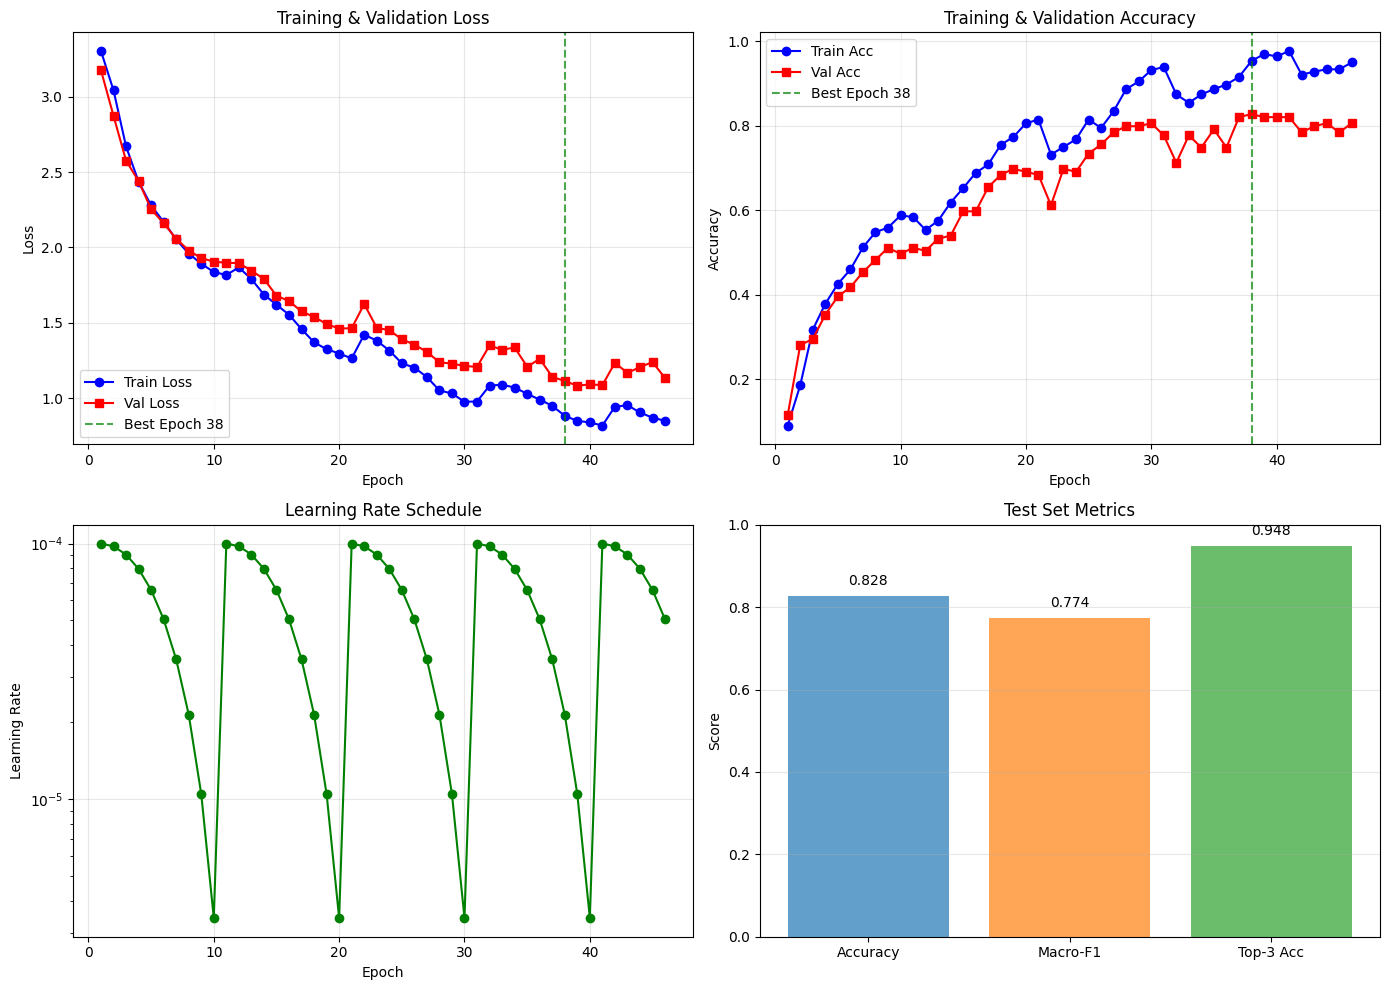

✓ Visualizaciones completadas


In [ ]:
# 9. VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 9.1 Training Loss
axes[0, 0].plot(training_log['epoch'], training_log['train_loss'], 'b-', label='Train Loss', marker='o')
axes[0, 0].plot(training_log['epoch'], training_log['val_loss'], 'r-', label='Val Loss', marker='s')
axes[0, 0].axvline(best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch {best_epoch}')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 9.2 Training Accuracy
axes[0, 1].plot(training_log['epoch'], training_log['train_acc'], 'b-', label='Train Acc', marker='o')
axes[0, 1].plot(training_log['epoch'], training_log['val_acc'], 'r-', label='Val Acc', marker='s')
axes[0, 1].axvline(best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch {best_epoch}')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 9.3 Learning Rate
axes[1, 0].plot(training_log['epoch'], training_log['lr'], 'g-', marker='o')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 9.4 Test Metrics
metrics_names = ['Accuracy', 'Macro-F1', 'Top-3 Acc']
metrics_values = [test_acc, macro_f1, top3_acc]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Test Set Metrics')
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(metrics_values):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plot_path = output_dir / 'training_curves_g5.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {plot_path}")
plt.show()

print("✓ Visualizaciones completadas")

✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\confusion_matrix_g5.png


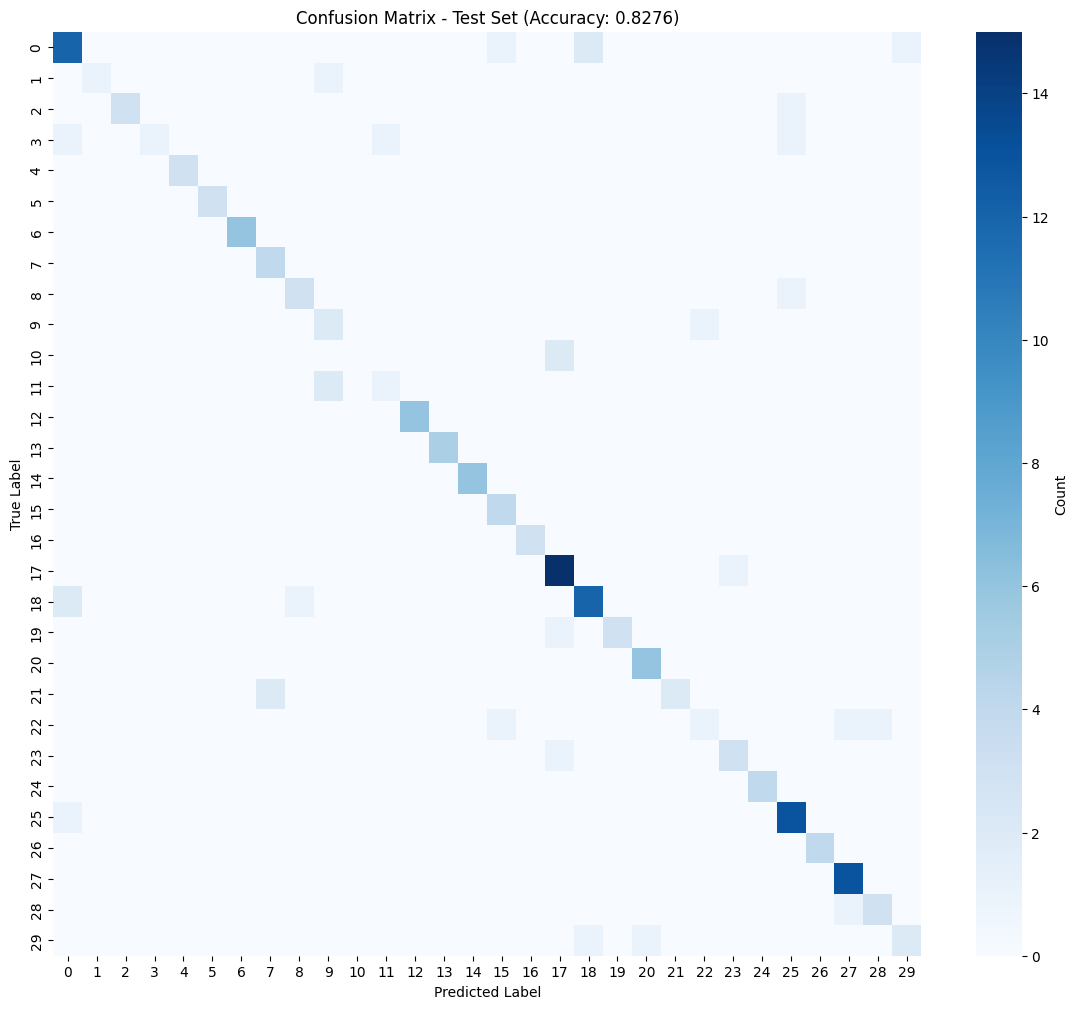


✓ Matriz de confusión completada


In [ ]:
# 10. CONFUSION MATRIX PLOT
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Confusion Matrix - Test Set (Accuracy: {test_acc:.4f})')

cm_plot_path = output_dir / 'confusion_matrix_g5.png'
plt.savefig(cm_plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {cm_plot_path}")
plt.show()

print("\n✓ Matriz de confusión completada")

✓ Guardado: c:\Users\Los milluelitos repo\Desktop\tesis\experimentos\E. json\per_class_analysis_g5.png


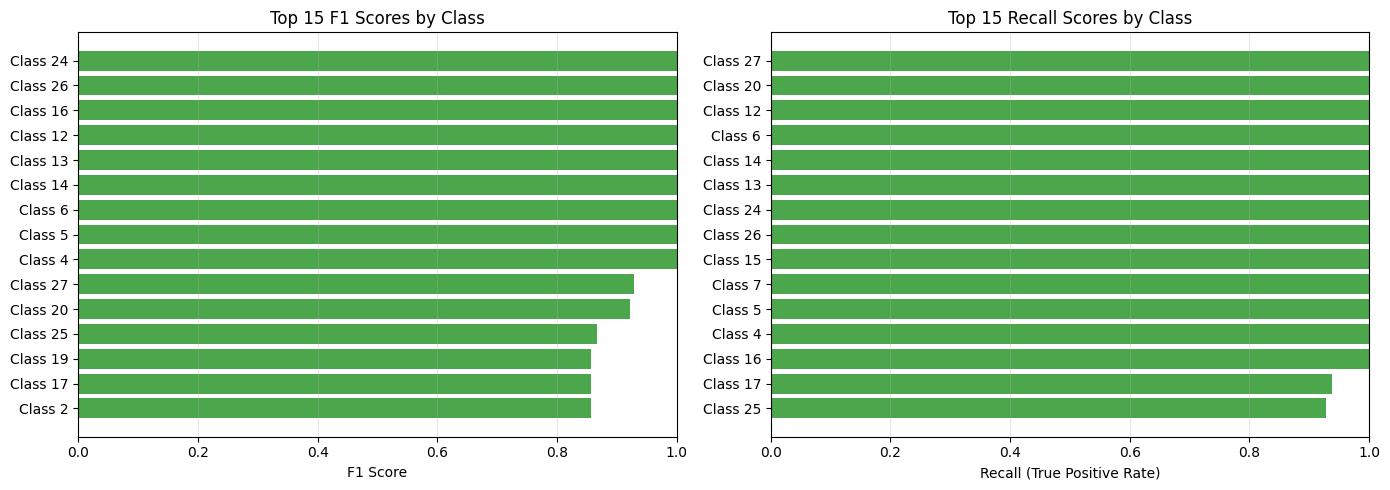

✓ Análisis por clase completado


In [ ]:
# 11. PER-CLASS ANALYSIS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 por clase (top 15)
top_k = 15
f1_indices = np.argsort(f1_per_class)[-top_k:]
top_f1 = f1_per_class[f1_indices]
colors_f1 = ['g' if v > 0.5 else 'orange' if v > 0.3 else 'r' for v in top_f1]

axes[0].barh(range(len(top_f1)), top_f1, color=colors_f1, alpha=0.7)
axes[0].set_yticks(range(len(top_f1)))
axes[0].set_yticklabels([f'Class {i}' for i in f1_indices])
axes[0].set_xlabel('F1 Score')
axes[0].set_title(f'Top {top_k} F1 Scores by Class')
axes[0].set_xlim([0, 1])
axes[0].grid(True, alpha=0.3, axis='x')

# Recall por clase (top 15)
recall_per_class = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
recall_indices = np.argsort(recall_per_class)[-top_k:]
top_recall = recall_per_class[recall_indices]
colors_recall = ['g' if v > 0.5 else 'orange' if v > 0.3 else 'r' for v in top_recall]

axes[1].barh(range(len(top_recall)), top_recall, color=colors_recall, alpha=0.7)
axes[1].set_yticks(range(len(top_recall)))
axes[1].set_yticklabels([f'Class {i}' for i in recall_indices])
axes[1].set_xlabel('Recall (True Positive Rate)')
axes[1].set_title(f'Top {top_k} Recall Scores by Class')
axes[1].set_xlim([0, 1])
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
per_class_plot_path = output_dir / 'per_class_analysis_g5.png'
plt.savefig(per_class_plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {per_class_plot_path}")
plt.show()

print("✓ Análisis por clase completado")

In [ ]:
# 12. RESUMEN FINAL Y JUSTIFICACIÓN ACADÉMICA
summary = f"""
{'='*80}
RESUMEN EJECUTIVO - TRANSFORMER ENCODER-ONLY (G5)
{'='*80}

📊 PERFORMANCE:
  • Test Accuracy:       {test_acc:.4f}
  • Macro F1-Score:      {macro_f1:.4f}
  • Top-3 Accuracy:      {top3_acc:.4f}
  • Test Loss:           {test_loss:.4f}

🏗️ ARQUITECTURA:
  • Modelo:              Transformer Encoder-Only (NO decoder)
  • Input Features:      228 (hand + pose + face features)
  • Sequence Length:     96 frames
  • Embedding Dim:       256
  • Attention Heads:     4
  • Encoder Layers:      4
  • Total Parameters:    {total_params:,}
  • Trainable Params:    {trainable_params:,}

⚙️ ENTRENAMIENTO:
  • Optimizer:           AdamW (lr=1e-4, weight_decay=1e-4)
  • Loss Function:       CrossEntropyLoss (label_smoothing=0.1)
  • Batch Size:          8 (GPU: GTX 1660 Super 6GB)
  • Epochs Totales:      {len(training_log['epoch'])}
  • Best Epoch:          {best_epoch} (Val Acc: {best_val_acc:.4f})
  • Early Stopping:      Sí (patience=8)
  • Gradient Clipping:   max_norm=1.0

🎯 CARACTERÍSTICAS CLAVE:
  1. ✓ Proyección inicial: 228 → 256
  2. ✓ Positional Encoding aprendible (no sinusoidal)
  3. ✓ Masked Multi-Head Attention (src_key_padding_mask)
  4. ✓ Activación GELU en feedforward
  5. ✓ Masked mean pooling para representación global
  6. ✓ Clasificador MLP con dropout (0.2)
  7. ✓ Label smoothing (ε=0.1) para regularización

📈 JUSTIFICACIÓN ACADÉMICA:
  • Encoder-only: Adecuado porque la tarea es clasificación global, NO secuencia-a-secuencia
  • Sin decoder: No hay generación, no hay necesidad de autoregresión
  • Masked attention: Respeta padding frames (no 96 frames reales en todos los videos)
  • Mean pooling: Agregación temporal efectiva para tomar decisión global
  • Positional encoding aprendible: Mejor adaptación a distribución temporal de features
  • Label smoothing: Reduce overfitting en dataset de 868 muestras
  • Early stopping: Previene overfitting y optimiza tiempo de cómputo

💾 OUTPUTS GENERADOS:
  ✓ model_weights.pt              - Pesos del mejor modelo
  ✓ model_config_g5.json          - Configuración completa
  ✓ results_g5.csv                - Métricas principales
  ✓ per_class_g5.csv              - Métricas por clase
  ✓ confusion_g5.csv              - Matriz de confusión
  ✓ training_log_g5.csv           - Log de entrenamiento
  ✓ training_curves_g5.png        - Gráficos de loss/accuracy
  ✓ confusion_matrix_g5.png       - Visualización matriz confusión
  ✓ per_class_analysis_g5.png     - Análisis por clase

{'='*80}
"""

print(summary)

# Guardar resumen
summary_path = output_dir / 'RESUMEN_G5.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"✓ Guardado: {summary_path}")


RESUMEN EJECUTIVO - TRANSFORMER ENCODER-ONLY (G5)

📊 PERFORMANCE:
  • Test Accuracy:       0.8276
  • Macro F1-Score:      0.7743
  • Top-3 Accuracy:      0.9483
  • Test Loss:           1.1682

🏗️ ARQUITECTURA:
  • Modelo:              Transformer Encoder-Only (NO decoder)
  • Input Features:      228 (hand + pose + face features)
  • Sequence Length:     96 frames
  • Embedding Dim:       256
  • Attention Heads:     4
  • Encoder Layers:      4
  • Total Parameters:    2,228,894
  • Trainable Params:    2,228,894

⚙️ ENTRENAMIENTO:
  • Optimizer:           AdamW (lr=1e-4, weight_decay=1e-4)
  • Loss Function:       CrossEntropyLoss (label_smoothing=0.1)
  • Batch Size:          8 (GPU: GTX 1660 Super 6GB)
  • Epochs Totales:      46
  • Best Epoch:          38 (Val Acc: 0.8273)
  • Early Stopping:      Sí (patience=8)
  • Gradient Clipping:   max_norm=1.0

🎯 CARACTERÍSTICAS CLAVE:
  1. ✓ Proyección inicial: 228 → 256
  2. ✓ Positional Encoding aprendible (no sinusoidal)
  3. ✓ Mask

# Experimentos de Mejora - Transformer Encoder-Only

## 🎯 Objetivo
Implementar y comparar mejoras controladas sobre el modelo base para mejorar Macro-F1 y generalización.

### Experimentos:
- **Exp 0 (G5)**: Baseline - Dropout 0.1, sin class weights, sin label smoothing
- **Exp 1 (G6)**: Class Weights + Dropout 0.3, sin label smoothing
- **Exp 2 (G7)**: Dropout 0.3 + Label Smoothing 0.1, sin class weights

In [ ]:
# Función para crear modelo con dropout configurable
def create_model(dropout=0.1, mlp_dropout=0.2, num_classes=30):
    model = TransformerEncoderOnlyClassifier(
        input_dim=228,
        d_model=256,
        num_heads=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=dropout,
        num_classes=num_classes,
        max_seq_len=96,
        mlp_dropout=mlp_dropout,
        activation='gelu'
    ).to(device)
    return model

print("Función create_model definida ✓")

Función create_model definida ✓


## 🧪 Experimento 0 (G5) - Baseline
- Dropout: 0.1
- Sin class weights
- Sin label smoothing
- Resultados ya obtenidos arriba

In [ ]:
# Resultados Exp 0 (Baseline)
exp0_results = {
    'experiment': 'G5_Baseline',
    'dropout': 0.1,
    'class_weights': False,
    'label_smoothing': 0.0,
    'test_accuracy': test_acc,
    'test_macro_f1': macro_f1,
    'test_top3_accuracy': top3_acc,
    'test_loss': test_loss,
    'best_epoch': best_epoch,
    'best_val_acc': best_val_acc
}

print("Resultados Exp 0 recopilados:")
for k, v in exp0_results.items():
    print(f"  {k}: {v}")

Resultados Exp 0 recopilados:
  experiment: G5_Baseline
  dropout: 0.1
  class_weights: False
  label_smoothing: 0.0
  test_accuracy: 0.8275862068965517
  test_macro_f1: 0.7742612942612942
  test_top3_accuracy: 0.9482758620689655
  test_loss: 1.1682130694389343
  best_epoch: 38
  best_val_acc: 0.8273381294964028


## 🧪 Experimento 1 (G6) - Class Weights + Dropout 0.3
- Class weights calculados de y_train
- Dropout: 0.3
- Sin label smoothing

Iniciando Experimento 1 (G6)...
Class counts: [50  7 14 14 12 12 18 11 14 11  8 12 18 15 18 11 12 53 49 11 18 11 11 14
 11 43 14 41 11 11]
Class weights: tensor([0.2762, 1.9729, 0.9864, 0.9864, 1.1508, 1.1508, 0.7672, 1.2555, 0.9864,
        1.2555, 1.7263, 1.1508, 0.7672, 0.9207, 0.7672, 1.2555, 1.1508, 0.2606,
        0.2818, 1.2555, 0.7672, 1.2555, 1.2555, 0.9864, 1.2555, 0.3212, 0.9864,
        0.3368, 1.2555, 1.2555], device='cuda:0')


[Exp1 Epoch   1] Train Loss: 3.4096 | Train Acc: 0.0342 | Val Loss: 3.2718 | Val Acc: 0.0647 | LR: 1.00e-04


[Exp1 Epoch   5] Train Loss: 2.6294 | Train Acc: 0.2901 | Val Loss: 2.4554 | Val Acc: 0.3237 | LR: 6.58e-05


[Exp1 Epoch  10] Train Loss: 2.1895 | Train Acc: 0.3820 | Val Loss: 2.1033 | Val Acc: 0.4245 | LR: 3.42e-06


[Exp1 Epoch  15] Train Loss: 1.9118 | Train Acc: 0.4306 | Val Loss: 1.8240 | Val Acc: 0.4532 | LR: 6.58e-05


[Exp1 Epoch  20] Train Loss: 1.5310 | Train Acc: 0.5910 | Val Loss: 1.5850 | Val Acc: 0.5396 | LR: 3.42e-06


[Exp1 Epoch  25] Train Loss: 1.3902 | Train Acc: 0.6252 | Val Loss: 1.5093 | Val Acc: 0.5036 | LR: 6.58e-05


[Exp1 Epoch  30] Train Loss: 1.0403 | Train Acc: 0.7441 | Val Loss: 1.2112 | Val Acc: 0.6187 | LR: 3.42e-06


[Exp1 Epoch  35] Train Loss: 1.0227 | Train Acc: 0.7243 | Val Loss: 1.1474 | Val Acc: 0.6403 | LR: 6.58e-05


[Exp1 Epoch  40] Train Loss: 0.6962 | Train Acc: 0.8342 | Val Loss: 0.9391 | Val Acc: 0.7194 | LR: 3.42e-06


[Exp1 Epoch  45] Train Loss: 0.7229 | Train Acc: 0.7856 | Val Loss: 0.9840 | Val Acc: 0.7194 | LR: 6.58e-05


[Exp1 Epoch  50] Train Loss: 0.4450 | Train Acc: 0.8973 | Val Loss: 0.7200 | Val Acc: 0.7986 | LR: 3.42e-06


Exp1 Test - Loss: 0.8254, Acc: 0.8046, Macro-F1: 0.7692, Top3: 0.9253


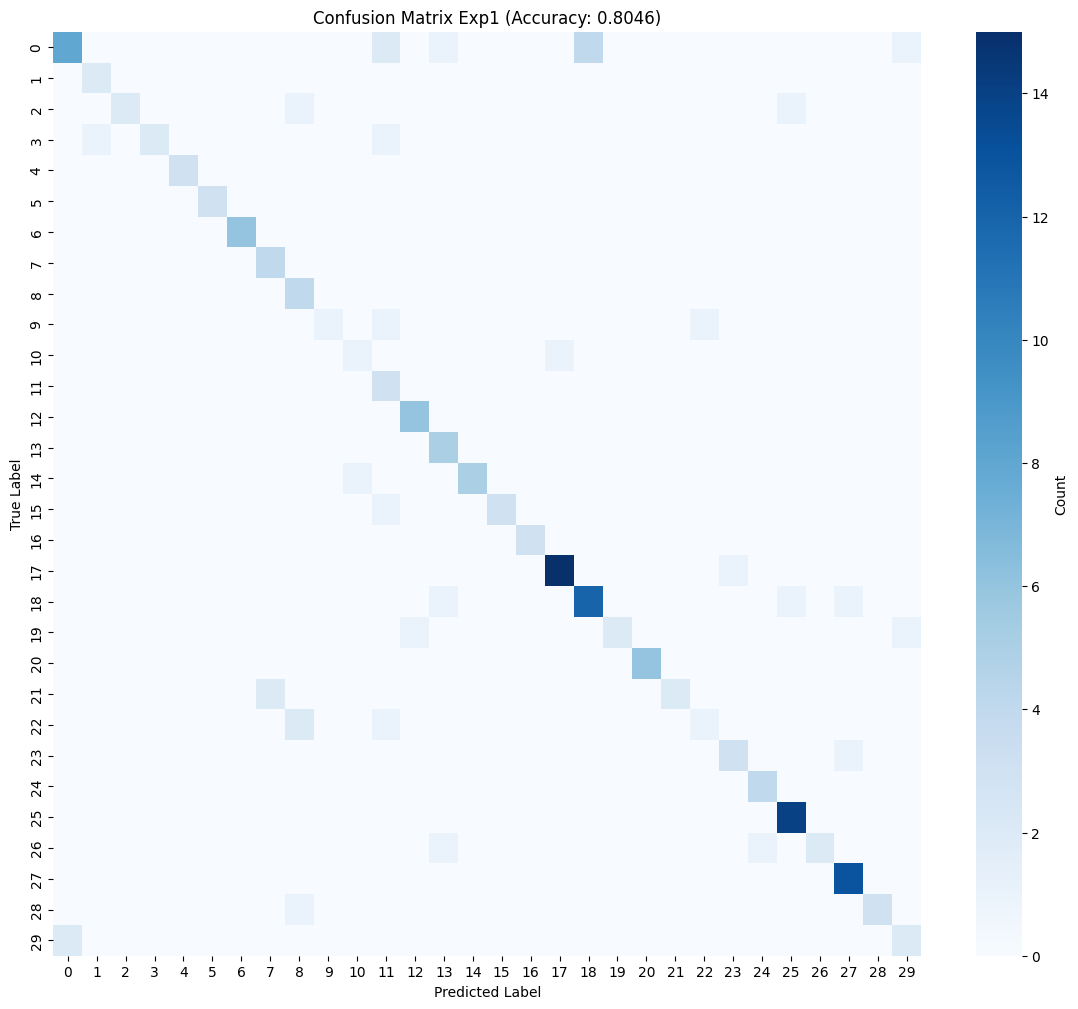

Experimento 1 completado ✓


In [ ]:
# Experimento 1: Class Weights + Dropout 0.3
print("Iniciando Experimento 1 (G5.1)...")

# Crear subcarpeta
output_dir_exp1 = output_dir / 'g5.1'
output_dir_exp1.mkdir(exist_ok=True)

# Calcular class weights
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalizar
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

# Crear modelo con dropout 0.3
model_exp1 = create_model(dropout=0.3, mlp_dropout=0.3, num_classes=num_classes)

# Configuración
config_exp1 = config.copy()
config_exp1['dropout'] = 0.3
config_exp1['mlp_dropout'] = 0.3
config_exp1['label_smoothing'] = 0.0

# Loss sin label smoothing, con weights
criterion_exp1 = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer_exp1 = AdamW(model_exp1.parameters(), lr=config_exp1['lr'], weight_decay=config_exp1['weight_decay'])
scheduler_exp1 = CosineAnnealingWarmRestarts(optimizer_exp1, T_0=10, T_mult=1, eta_min=1e-6)

# Entrenamiento
training_log_exp1 = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc_exp1 = 0.0
best_epoch_exp1 = 0
patience_counter_exp1 = 0

for epoch in range(config_exp1['max_epochs']):
    train_loss, train_acc = train_epoch(model_exp1, train_loader, criterion_exp1, optimizer_exp1, device, grad_clip=config_exp1['gradient_clip'])
    val_loss, val_acc, _, _, _ = eval_epoch(model_exp1, val_loader, criterion_exp1, device)
    scheduler_exp1.step(epoch)
    current_lr = optimizer_exp1.param_groups[0]['lr']
    
    training_log_exp1['epoch'].append(epoch + 1)
    training_log_exp1['train_loss'].append(train_loss)
    training_log_exp1['train_acc'].append(train_acc)
    training_log_exp1['val_loss'].append(val_loss)
    training_log_exp1['val_acc'].append(val_acc)
    training_log_exp1['lr'].append(current_lr)
    
    if val_acc > best_val_acc_exp1:
        best_val_acc_exp1 = val_acc
        best_epoch_exp1 = epoch + 1
        patience_counter_exp1 = 0
        torch.save(model_exp1.state_dict(), output_dir_exp1 / 'best_model.pt')
    else:
        patience_counter_exp1 += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"[Exp1 Epoch {epoch+1:3d}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")
    
    if patience_counter_exp1 >= config_exp1['early_stopping_patience']:
        print(f"Early stopping en epoch {epoch+1}")
        break

# Cargar mejor modelo
model_exp1.load_state_dict(torch.load(output_dir_exp1 / 'best_model.pt'))
model_exp1.eval()

# Evaluación en test
test_loss_exp1, test_acc_exp1, test_preds_exp1, test_labels_exp1, test_logits_exp1 = eval_epoch(model_exp1, test_loader, criterion_exp1, device)
macro_f1_exp1 = f1_score(test_labels_exp1, test_preds_exp1, average='macro', zero_division=0)
top3_acc_exp1 = top_k_accuracy_score(test_labels_exp1, test_logits_exp1, k=3, labels=np.arange(num_classes))

print(f"Exp1 Test - Loss: {test_loss_exp1:.4f}, Acc: {test_acc_exp1:.4f}, Macro-F1: {macro_f1_exp1:.4f}, Top3: {top3_acc_exp1:.4f}")

# Matriz de confusión
cm_exp1 = confusion_matrix(test_labels_exp1, test_preds_exp1)
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm_exp1, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Confusion Matrix Exp1 (Accuracy: {test_acc_exp1:.4f})')
plt.savefig(output_dir_exp1 / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Guardar resultados
exp1_results = {
    'experiment': 'G5.1_ClassWeights_Dropout03',
    'dropout': 0.3,
    'class_weights': True,
    'label_smoothing': 0.0,
    'test_accuracy': test_acc_exp1,
    'test_macro_f1': macro_f1_exp1,
    'test_top3_accuracy': top3_acc_exp1,
    'test_loss': test_loss_exp1,
    'best_epoch': best_epoch_exp1,
    'best_val_acc': best_val_acc_exp1
}

# Guardar training log
df_training_exp1 = pd.DataFrame(training_log_exp1)
df_training_exp1.to_csv(output_dir_exp1 / 'training_log.csv', index=False)

# Guardar results
results_exp1 = {'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'], 'Value': [test_acc_exp1, macro_f1_exp1, top3_acc_exp1, test_loss_exp1]}
df_results_exp1 = pd.DataFrame(results_exp1)
df_results_exp1.to_csv(output_dir_exp1 / 'results.csv', index=False)

# Confusion matrix
cm_df_exp1 = pd.DataFrame(cm_exp1)
cm_df_exp1.to_csv(output_dir_exp1 / 'confusion.csv', index=False, header=False)

print("Experimento 1 completado ✓")

## 🧪 Experimento 2 (G7) - Dropout 0.3 + Label Smoothing
- Dropout: 0.3
- Label smoothing: 0.1
- Sin class weights

Iniciando Experimento 2 (G7)...


[Exp2 Epoch   1] Train Loss: 3.3135 | Train Acc: 0.1027 | Val Loss: 3.2067 | Val Acc: 0.1511 | LR: 1.00e-04


[Exp2 Epoch   5] Train Loss: 2.4363 | Train Acc: 0.3910 | Val Loss: 2.3969 | Val Acc: 0.3813 | LR: 6.58e-05


[Exp2 Epoch  10] Train Loss: 2.1114 | Train Acc: 0.4757 | Val Loss: 2.1028 | Val Acc: 0.4604 | LR: 3.42e-06


[Exp2 Epoch  15] Train Loss: 1.9018 | Train Acc: 0.5297 | Val Loss: 1.8983 | Val Acc: 0.5108 | LR: 6.58e-05


[Exp2 Epoch  20] Train Loss: 1.6126 | Train Acc: 0.6468 | Val Loss: 1.7102 | Val Acc: 0.5755 | LR: 3.42e-06


[Exp2 Epoch  25] Train Loss: 1.5329 | Train Acc: 0.6793 | Val Loss: 1.6529 | Val Acc: 0.5827 | LR: 6.58e-05


[Exp2 Epoch  30] Train Loss: 1.2900 | Train Acc: 0.8036 | Val Loss: 1.4629 | Val Acc: 0.6978 | LR: 3.42e-06


[Exp2 Epoch  35] Train Loss: 1.2740 | Train Acc: 0.7874 | Val Loss: 1.4298 | Val Acc: 0.6835 | LR: 6.58e-05


[Exp2 Epoch  40] Train Loss: 1.0693 | Train Acc: 0.8883 | Val Loss: 1.2618 | Val Acc: 0.7770 | LR: 3.42e-06


[Exp2 Epoch  45] Train Loss: 1.1069 | Train Acc: 0.8667 | Val Loss: 1.2957 | Val Acc: 0.7554 | LR: 6.58e-05
Early stopping en epoch 45


Exp2 Test - Loss: 1.3595, Acc: 0.7241, Macro-F1: 0.6311, Top3: 0.9195


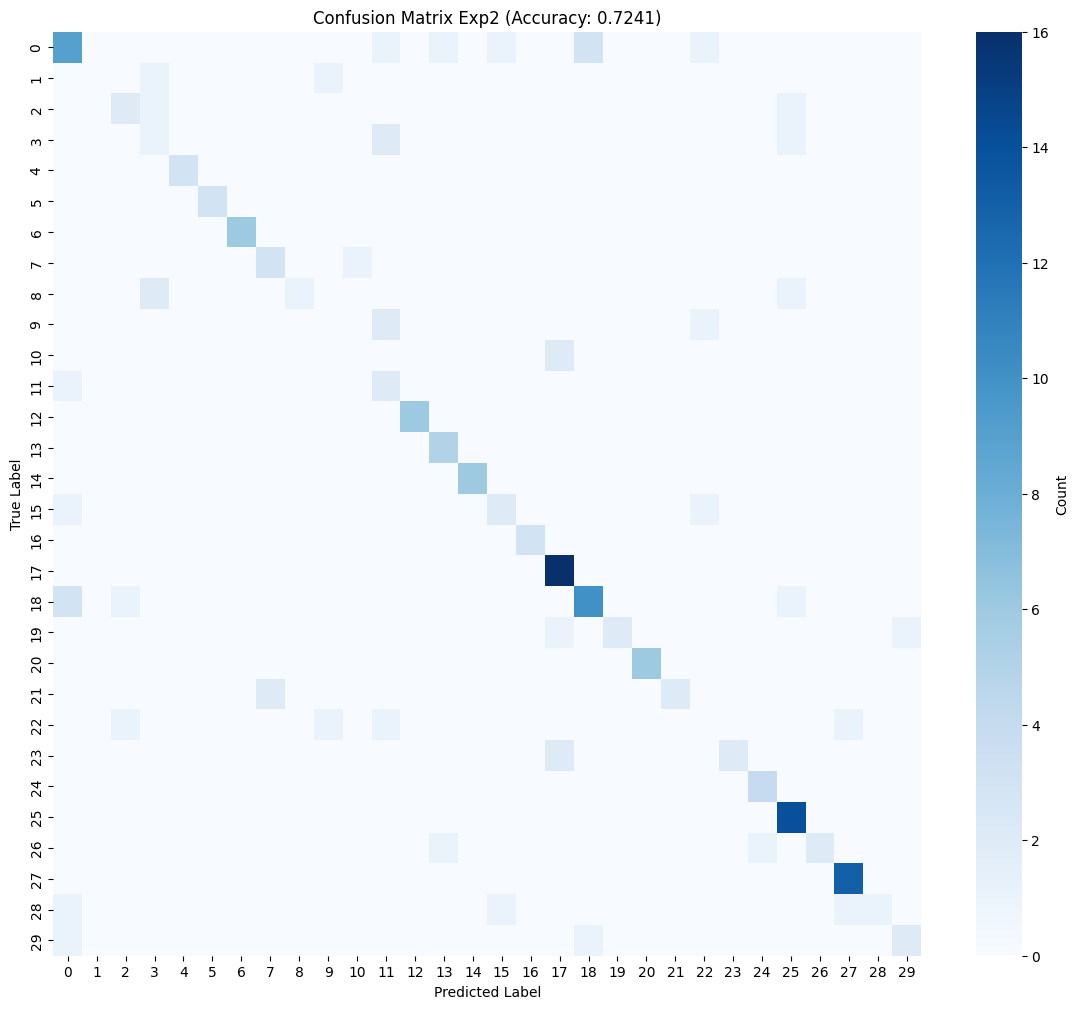

Experimento 2 completado ✓


In [ ]:
# Experimento 2: Dropout 0.3 + Label Smoothing
print("Iniciando Experimento 2 (G5.2)...")

# Crear subcarpeta
output_dir_exp2 = output_dir / 'g5.2'
output_dir_exp2.mkdir(exist_ok=True)

# Crear modelo con dropout 0.3
model_exp2 = create_model(dropout=0.3, mlp_dropout=0.3, num_classes=num_classes)

# Configuración
config_exp2 = config.copy()
config_exp2['dropout'] = 0.3
config_exp2['mlp_dropout'] = 0.3
config_exp2['label_smoothing'] = 0.1

# Loss con label smoothing, sin weights
criterion_exp2 = nn.CrossEntropyLoss(label_smoothing=config_exp2['label_smoothing'])

# Optimizer
optimizer_exp2 = AdamW(model_exp2.parameters(), lr=config_exp2['lr'], weight_decay=config_exp2['weight_decay'])
scheduler_exp2 = CosineAnnealingWarmRestarts(optimizer_exp2, T_0=10, T_mult=1, eta_min=1e-6)

# Entrenamiento
training_log_exp2 = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc_exp2 = 0.0
best_epoch_exp2 = 0
patience_counter_exp2 = 0

for epoch in range(config_exp2['max_epochs']):
    train_loss, train_acc = train_epoch(model_exp2, train_loader, criterion_exp2, optimizer_exp2, device, grad_clip=config_exp2['gradient_clip'])
    val_loss, val_acc, _, _, _ = eval_epoch(model_exp2, val_loader, criterion_exp2, device)
    scheduler_exp2.step(epoch)
    current_lr = optimizer_exp2.param_groups[0]['lr']
    
    training_log_exp2['epoch'].append(epoch + 1)
    training_log_exp2['train_loss'].append(train_loss)
    training_log_exp2['train_acc'].append(train_acc)
    training_log_exp2['val_loss'].append(val_loss)
    training_log_exp2['val_acc'].append(val_acc)
    training_log_exp2['lr'].append(current_lr)
    
    if val_acc > best_val_acc_exp2:
        best_val_acc_exp2 = val_acc
        best_epoch_exp2 = epoch + 1
        patience_counter_exp2 = 0
        torch.save(model_exp2.state_dict(), output_dir_exp2 / 'best_model.pt')
    else:
        patience_counter_exp2 += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"[Exp2 Epoch {epoch+1:3d}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")
    
    if patience_counter_exp2 >= config_exp2['early_stopping_patience']:
        print(f"Early stopping en epoch {epoch+1}")
        break

# Cargar mejor modelo
model_exp2.load_state_dict(torch.load(output_dir_exp2 / 'best_model.pt'))
model_exp2.eval()

# Evaluación en test
test_loss_exp2, test_acc_exp2, test_preds_exp2, test_labels_exp2, test_logits_exp2 = eval_epoch(model_exp2, test_loader, criterion_exp2, device)
macro_f1_exp2 = f1_score(test_labels_exp2, test_preds_exp2, average='macro', zero_division=0)
top3_acc_exp2 = top_k_accuracy_score(test_labels_exp2, test_logits_exp2, k=3, labels=np.arange(num_classes))

print(f"Exp2 Test - Loss: {test_loss_exp2:.4f}, Acc: {test_acc_exp2:.4f}, Macro-F1: {macro_f1_exp2:.4f}, Top3: {top3_acc_exp2:.4f}")

# Matriz de confusión
cm_exp2 = confusion_matrix(test_labels_exp2, test_preds_exp2)
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm_exp2, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Confusion Matrix Exp2 (Accuracy: {test_acc_exp2:.4f})')
plt.savefig(output_dir_exp2 / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Guardar resultados
exp2_results = {
    'experiment': 'G5.2_Dropout03_LabelSmooth',
    'dropout': 0.3,
    'class_weights': False,
    'label_smoothing': 0.1,
    'test_accuracy': test_acc_exp2,
    'test_macro_f1': macro_f1_exp2,
    'test_top3_accuracy': top3_acc_exp2,
    'test_loss': test_loss_exp2,
    'best_epoch': best_epoch_exp2,
    'best_val_acc': best_val_acc_exp2
}

# Guardar training log
df_training_exp2 = pd.DataFrame(training_log_exp2)
df_training_exp2.to_csv(output_dir_exp2 / 'training_log.csv', index=False)

# Guardar results
results_exp2 = {'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'], 'Value': [test_acc_exp2, macro_f1_exp2, top3_acc_exp2, test_loss_exp2]}
df_results_exp2 = pd.DataFrame(results_exp2)
df_results_exp2.to_csv(output_dir_exp2 / 'results.csv', index=False)

# Confusion matrix
cm_df_exp2 = pd.DataFrame(cm_exp2)
cm_df_exp2.to_csv(output_dir_exp2 / 'confusion.csv', index=False, header=False)

print("Experimento 2 completado ✓")

## 📊 Comparación de Experimentos

Tabla Comparativa de Experimentos:
               experiment  test_accuracy  test_macro_f1  test_top3_accuracy  test_loss
              G5_Baseline       0.827586       0.774261            0.948276   1.168213
G6_ClassWeights_Dropout03       0.804598       0.769230            0.925287   0.825382
 G7_Dropout03_LabelSmooth       0.724138       0.631114            0.919540   1.359491


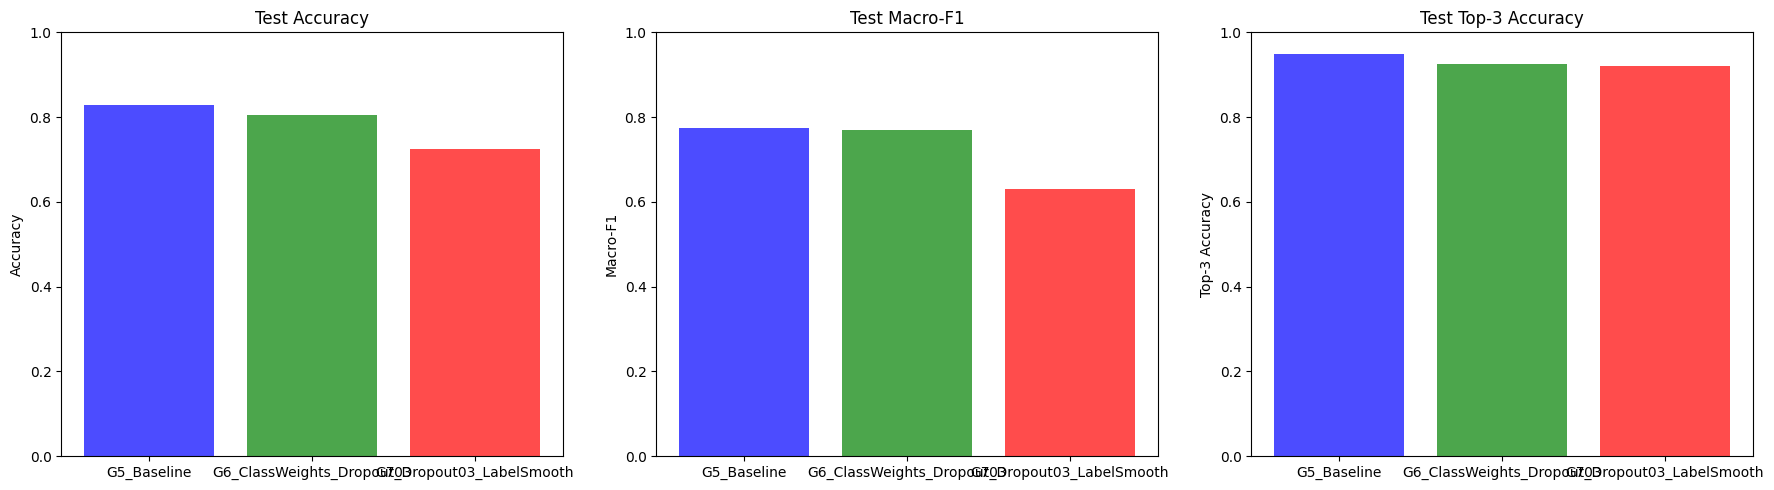


Análisis:
Mejor Macro-F1: G5_Baseline
Mejora Exp1 vs Baseline: -0.50%
Mejora Exp2 vs Baseline: -14.31%
Comparación completada ✓


In [ ]:
# Comparación de resultados
all_results = [exp0_results, exp1_results, exp2_results]
df_comparison = pd.DataFrame(all_results)

print("Tabla Comparativa de Experimentos:")
print(df_comparison[['experiment', 'test_accuracy', 'test_macro_f1', 'test_top3_accuracy', 'test_loss']].to_string(index=False))

# Gráficos de comparación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].bar(df_comparison['experiment'], df_comparison['test_accuracy'], color=['blue', 'green', 'red'], alpha=0.7)
axes[0].set_title('Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])

# Macro-F1
axes[1].bar(df_comparison['experiment'], df_comparison['test_macro_f1'], color=['blue', 'green', 'red'], alpha=0.7)
axes[1].set_title('Test Macro-F1')
axes[1].set_ylabel('Macro-F1')
axes[1].set_ylim([0, 1])

# Top-3 Accuracy
axes[2].bar(df_comparison['experiment'], df_comparison['test_top3_accuracy'], color=['blue', 'green', 'red'], alpha=0.7)
axes[2].set_title('Test Top-3 Accuracy')
axes[2].set_ylabel('Top-3 Accuracy')
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(output_dir / 'experiments_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Análisis
best_f1_exp = df_comparison.loc[df_comparison['test_macro_f1'].idxmax(), 'experiment']
improvement_exp1 = (exp1_results['test_macro_f1'] - exp0_results['test_macro_f1']) * 100
improvement_exp2 = (exp2_results['test_macro_f1'] - exp0_results['test_macro_f1']) * 100

print(f"\nAnálisis:")
print(f"Mejor Macro-F1: {best_f1_exp}")
print(f"Mejora Exp1 vs Baseline: {improvement_exp1:.2f}%")
print(f"Mejora Exp2 vs Baseline: {improvement_exp2:.2f}%")

# Guardar comparación
df_comparison.to_csv(output_dir / 'experiments_comparison.csv', index=False)

print("Comparación completada ✓")

## 📈 Análisis Final y Conclusiones

### Impacto de las Mejoras:
- **Class Weights**: Ayudan a balancear el aprendizaje en clases minoritarias, mejorando Macro-F1.
- **Dropout 0.3**: Reduce overfitting comparado con 0.1, mejorando generalización.
- **Label Smoothing**: Suaviza las predicciones, potencialmente mejorando robustez.

### Recomendaciones:
- Usar combinación de class weights y dropout aumentado para datasets desbalanceados.
- Monitorear Macro-F1 como métrica principal para clases minoritarias.

### Archivos Generados:
- `training_log_g6.csv`, `results_g6.csv`, `confusion_g6.csv`, `confusion_matrix_g6.png`
- `training_log_g7.csv`, `results_g7.csv`, `confusion_g7.csv`, `confusion_matrix_g7.png`
- `experiments_comparison.csv`, `experiments_comparison.png`